# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

from sklearn.preprocessing import (StandardScaler)
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.linear_model import(LinearRegression, 
                                 Lasso, 
                                 Ridge,
                                 ElasticNet)
from sklearn.ensemble import(RandomForestRegressor, 
                            GradientBoostingRegressor, 
                            AdaBoostRegressor)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import(r2_score,
                            root_mean_squared_error,
                            mean_absolute_error)

from sklearn.feature_selection import mutual_info_regression

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.compose import ColumnTransformer

warnings.filterwarnings("ignore")


# Reading the data

In [2]:
df = pd.read_csv('/Users/suryasaikadali/Downloads/pw_skills/kaggle/insurance_prediction/artifacts/insurance.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [4]:
# checking the shape
df.shape

(1338, 7)

In [5]:
# checking the sum of null values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
# descriptive statistics of numerical data
df.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


In [8]:
# numerical columns
num_cols = [i for i in df.columns if df[i].dtype in ('float64','int64')]

In [9]:
num_cols

['age', 'bmi', 'children', 'expenses']

In [10]:
# categorical columns
cat_cols = [i for i in df.columns if df[i].dtype == 'O']

In [11]:
cat_cols

['sex', 'smoker', 'region']

## Distribution of age

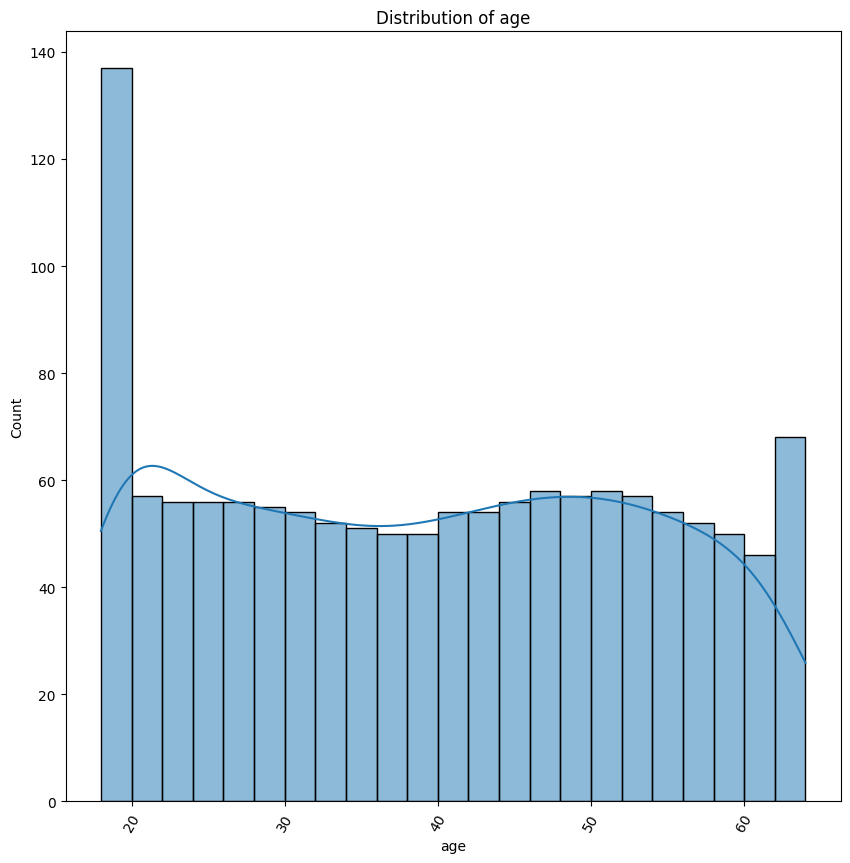

In [12]:
plt.figure(figsize = (10,10))
plt.title('Distribution of age')
sns.histplot(data = df,
             x = 'age',
             binwidth =2,
             kde = True)

plt.xticks(rotation = 60);


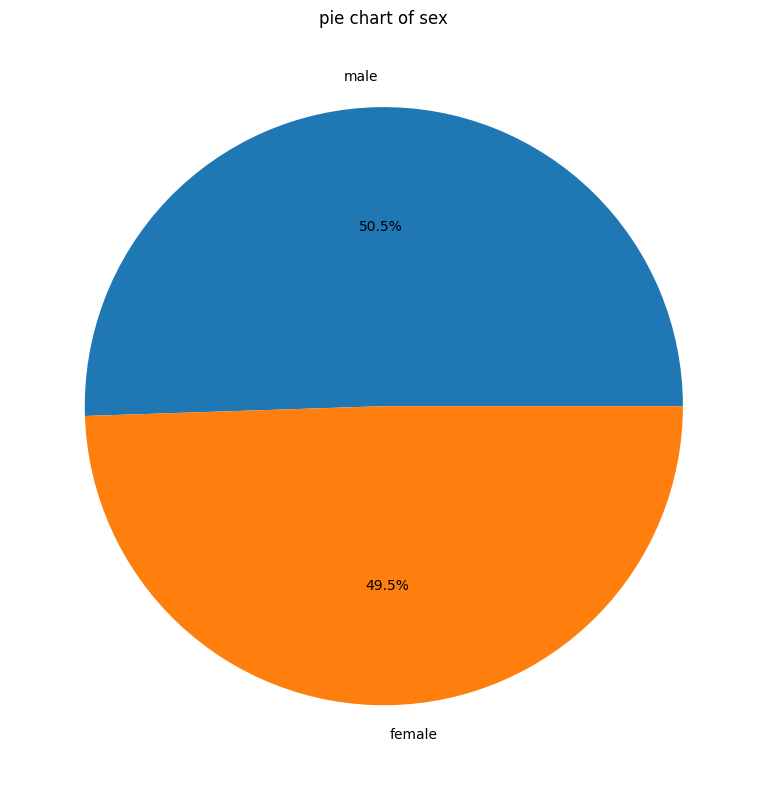

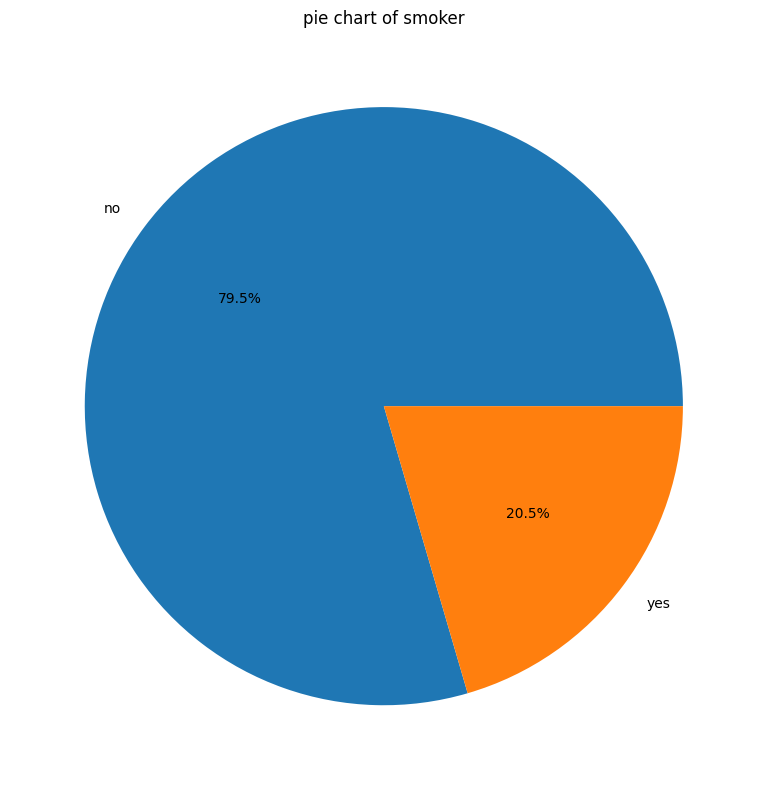

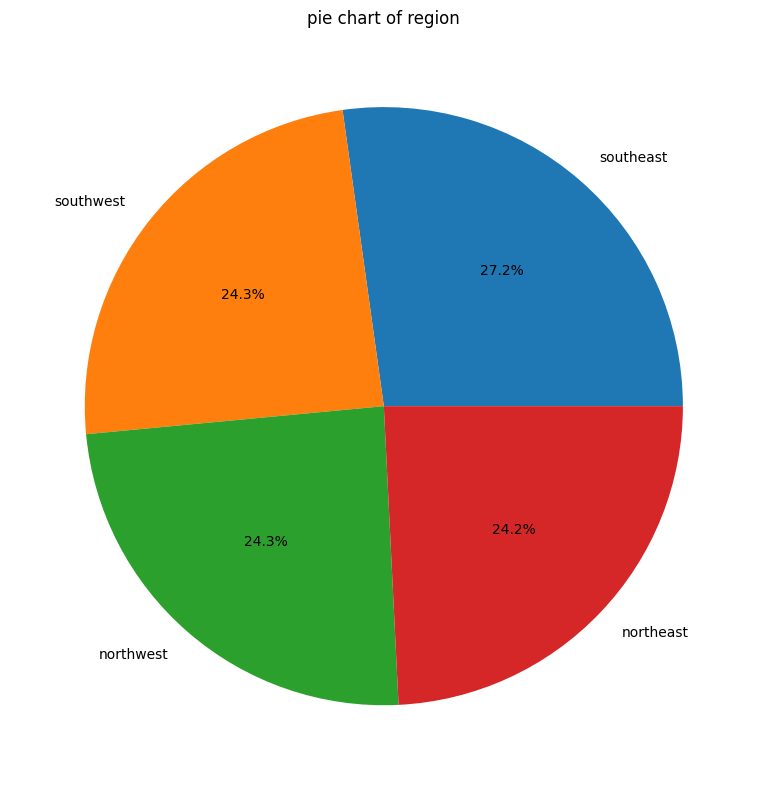

In [13]:
# pie chart of categorical columns
for i,col in enumerate(cat_cols):
    plt.figure(figsize = (8,8))
    plt.title(label= f'pie chart of {col}',
              loc = 'center')
    #plt.subplot(3,1,i+1)
    plt.pie(df[col].value_counts(),
            labels=df[col].value_counts().index,  
            autopct = '%1.1f%%')
    plt.tight_layout()

## Distribution of children

In [14]:
df['children'].value_counts()

children
0    574
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64

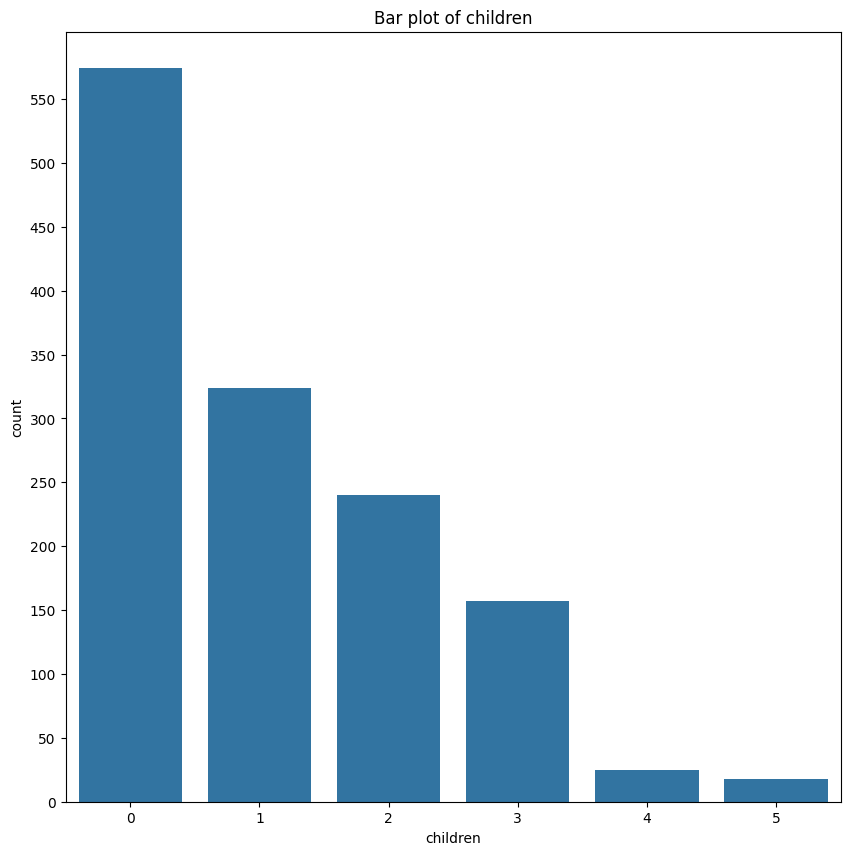

In [15]:
# bar plot
plt.figure(figsize = (10,10))
plt.title('Bar plot of children')
sns.countplot(data = df,
              x = 'children',)
plt.yticks(np.arange(0,600,50));

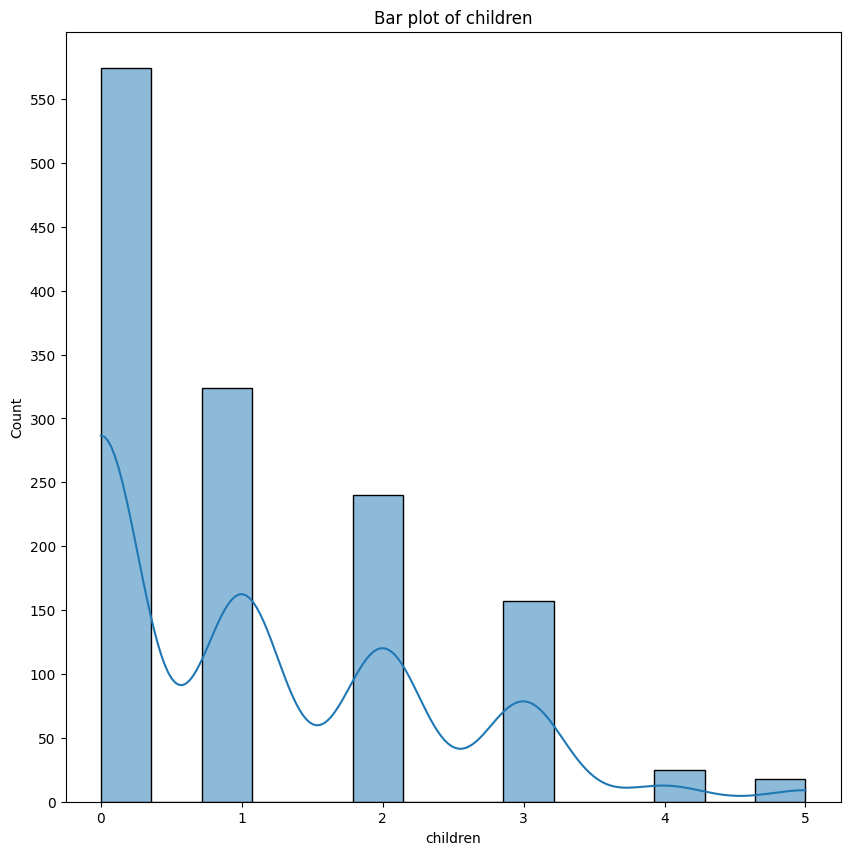

In [16]:
# plotting histogram 
plt.figure(figsize = (10,10))
plt.title('Bar plot of children')
sns.histplot(data = df,
                 x = 'children',
                kde = True)
plt.yticks(np.arange(0,600,50));

## Distribution of bmi

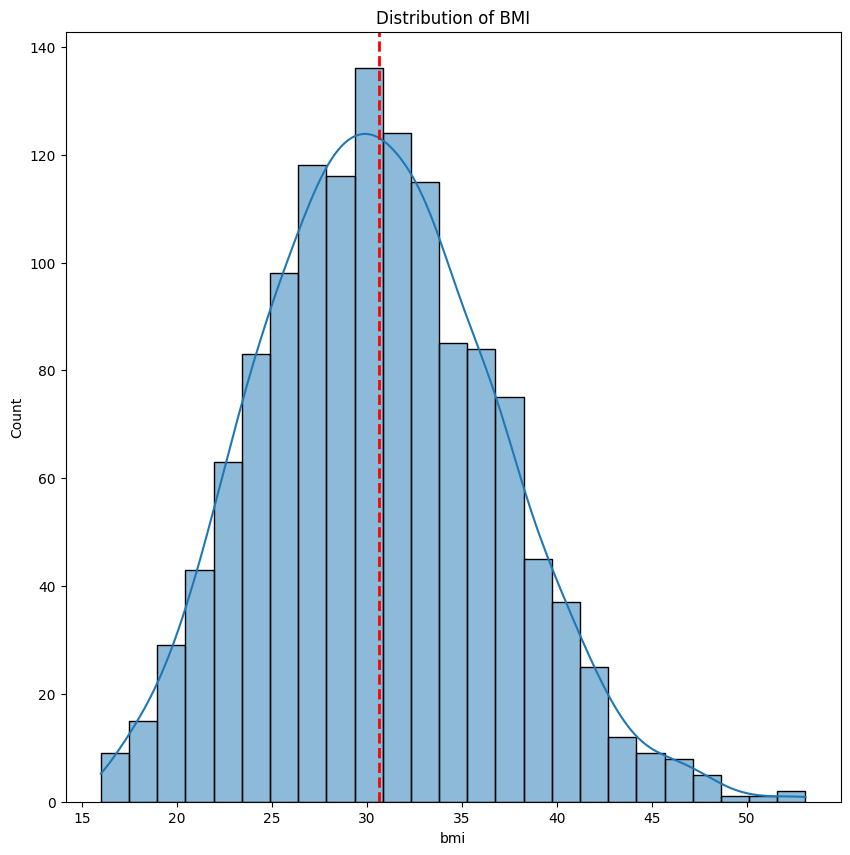

In [17]:
plt.figure(figsize = (10,10))
plt.title('Distribution of BMI')
sns.histplot(data = df,
             x = 'bmi',
             kde = True);
plt.axvline(x = df['bmi'].mean(),linestyle = '--',lw = 2,c = 'r');

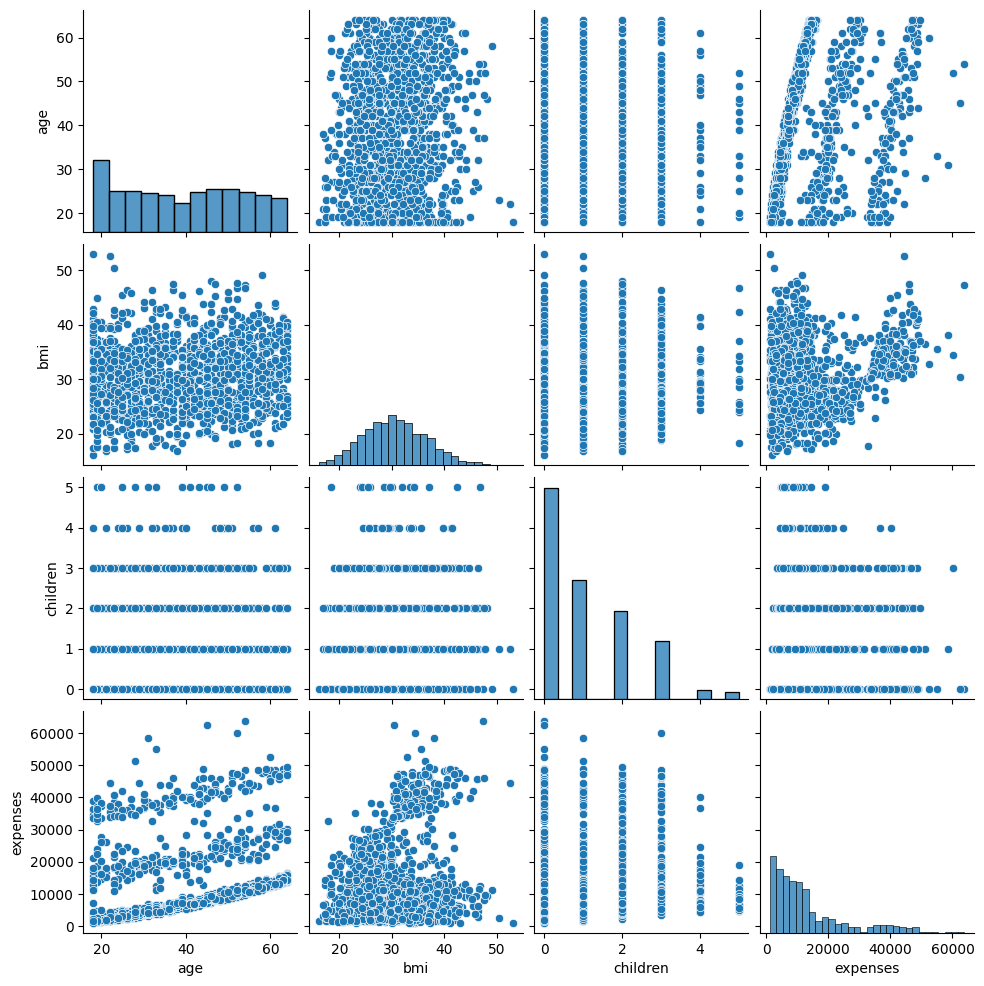

In [18]:
# comparing all the numerical columns with pair plot
sns.pairplot(df)

# checking the relation between smoker,age and expenses

In [19]:
# we are considering mean of expenses grouped by age and smoker
a1 = df.groupby(['smoker','age'])['expenses'].mean().reset_index()

In [20]:
a1.head()

,smoker,age,expenses
0,no,18,3215.162632
1,no,19,3536.713200
2,no,20,3673.113000
3,no,21,3813.530385
4,no,22,2551.017727


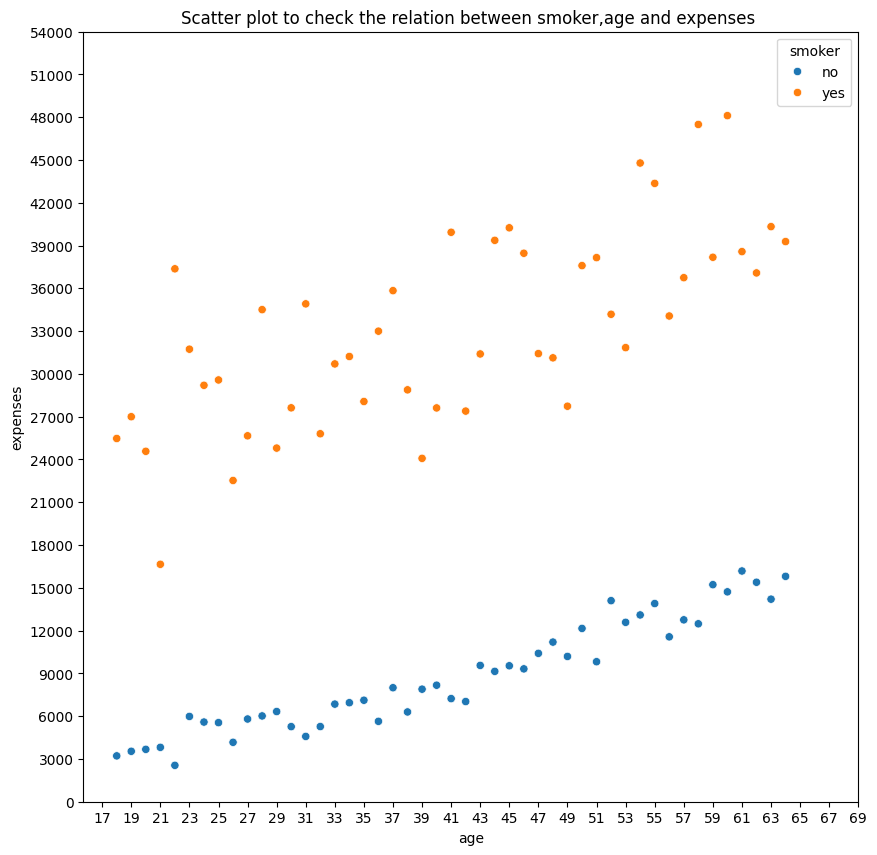

In [21]:
plt.figure(figsize = (10,10))
plt.title('Scatter plot to check the relation between smoker,age and expenses ')
sns.scatterplot(data = a1,
                x = 'age',
                y = 'expenses', 
                hue = 'smoker')
plt.yticks(np.arange(0,55000,3000));
plt.xticks(np.arange(17,70,2));

In [22]:
# checking also with median of expense
a2 = df.groupby(['smoker','age'])['expenses'].median().reset_index()

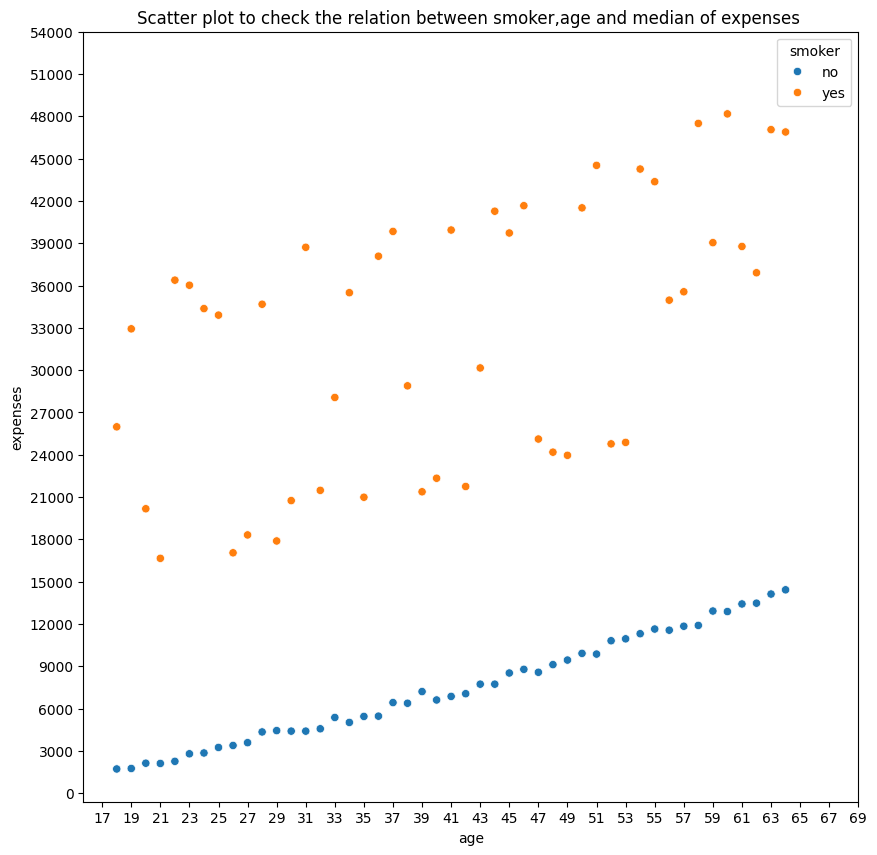

In [23]:
plt.figure(figsize = (10,10))
plt.title('Scatter plot to check the relation between smoker,age and median of expenses ')
sns.scatterplot(data = a2,
                x = 'age',
                y = 'expenses', 
                hue = 'smoker')
plt.yticks(np.arange(0,55000,3000));
plt.xticks(np.arange(17,70,2));

# checking the relation between smoker,age,sex,region and expenses

### using the estimator as mean

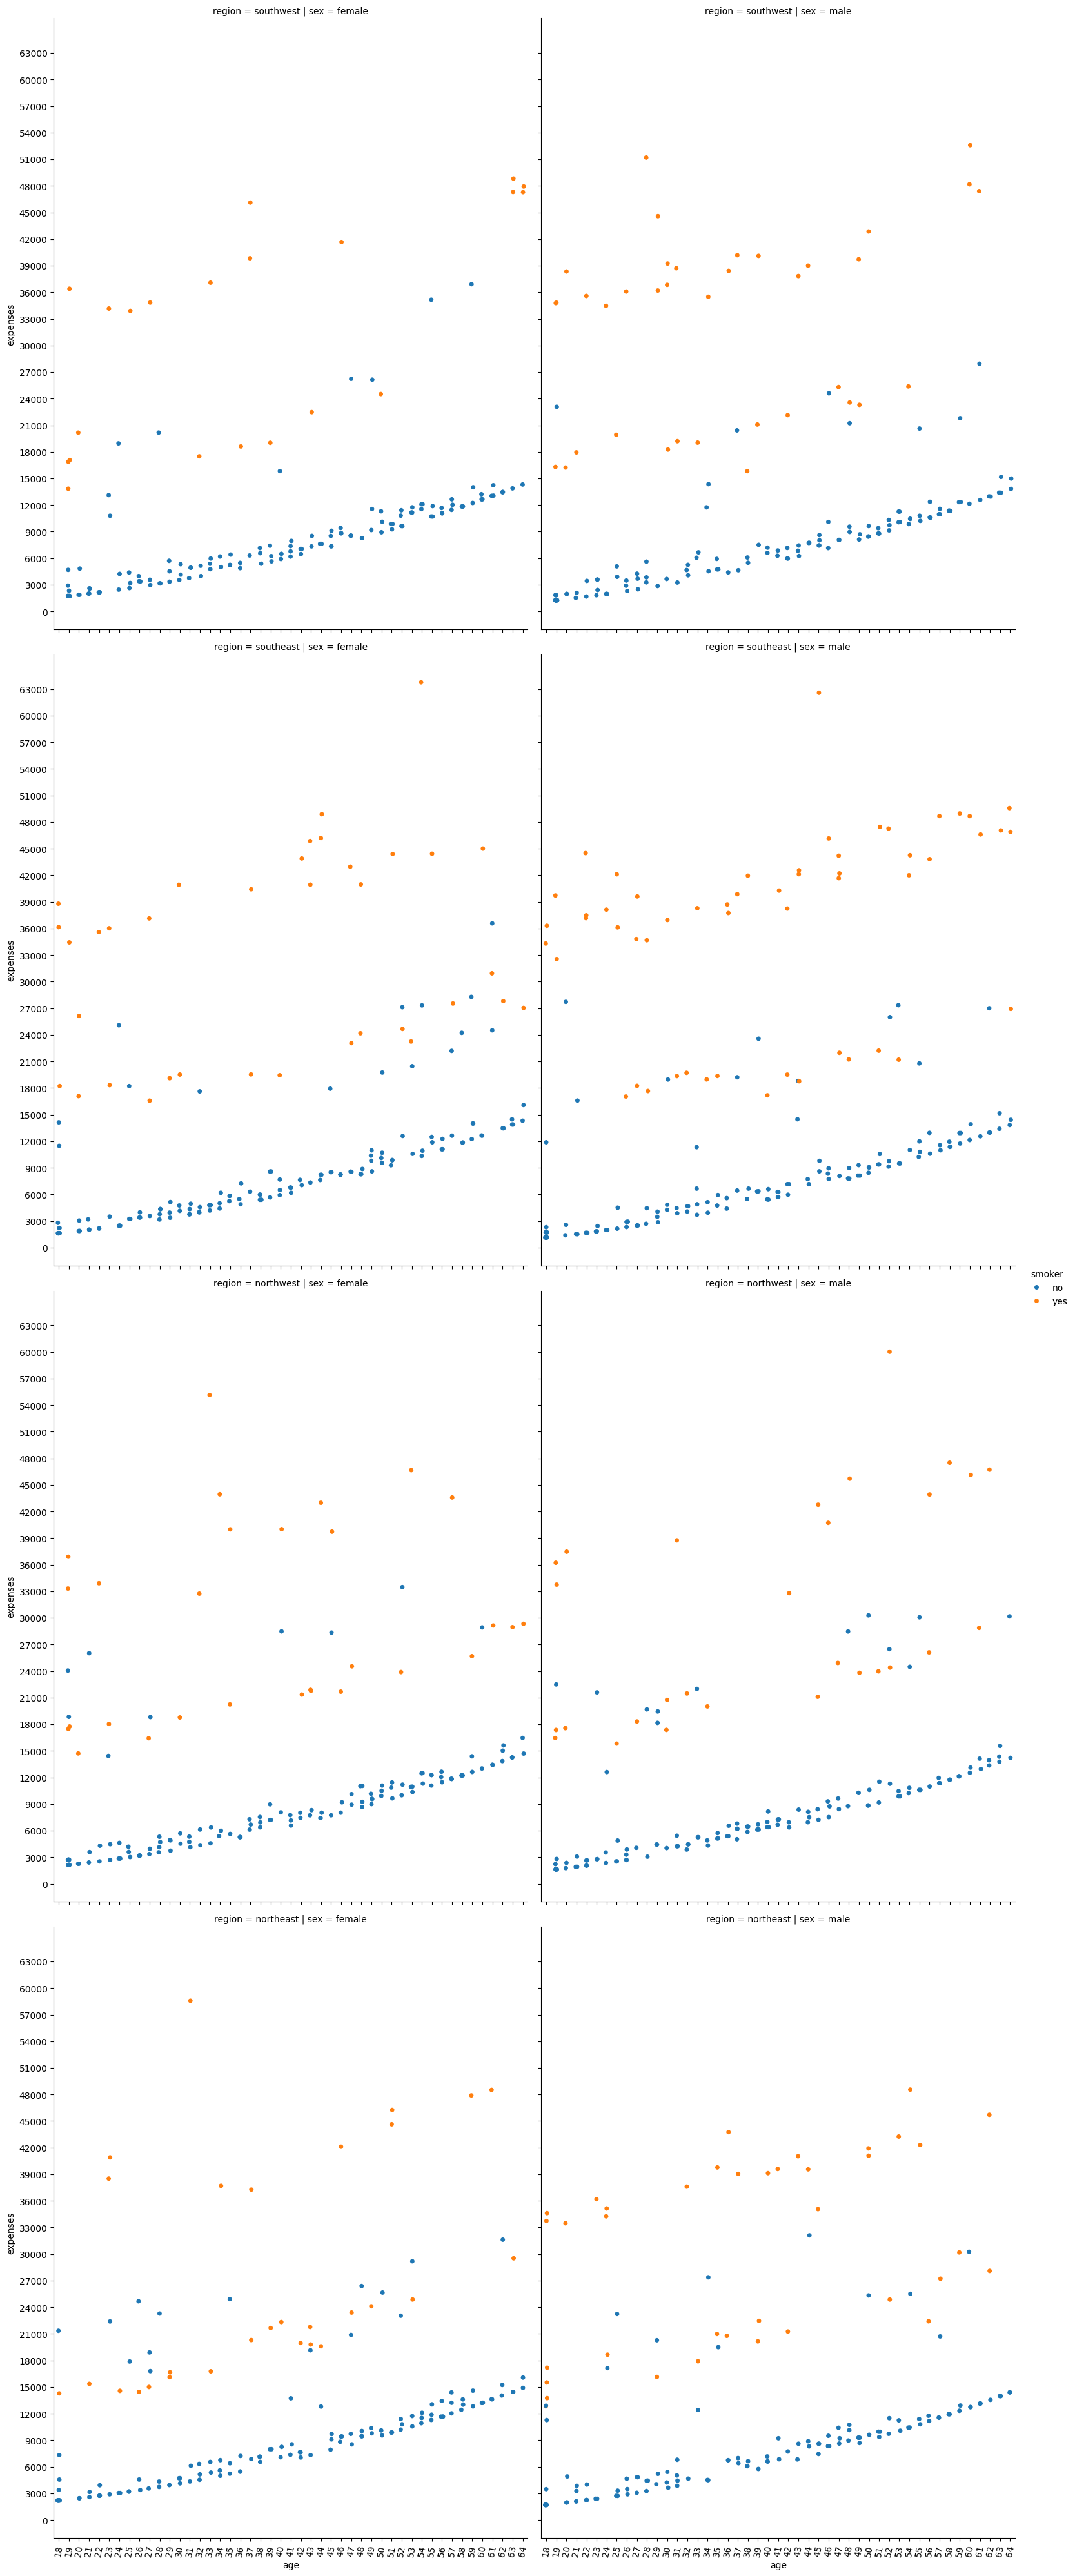

In [24]:
yticks = np.arange(0,64000,3000)
g = sns.catplot(data = df, 
                x = 'age', 
                y = 'expenses', 
                hue = 'smoker', 
                col = 'sex', 
                row = 'region', 
                height = 10, 
                aspect = 0.8,
                legend_out = True);

for ax in g.axes.flatten():
    ax.set_yticks(yticks)
    for label in ax.get_xticklabels():
        label.set_rotation(80)

#### using the estimator as median

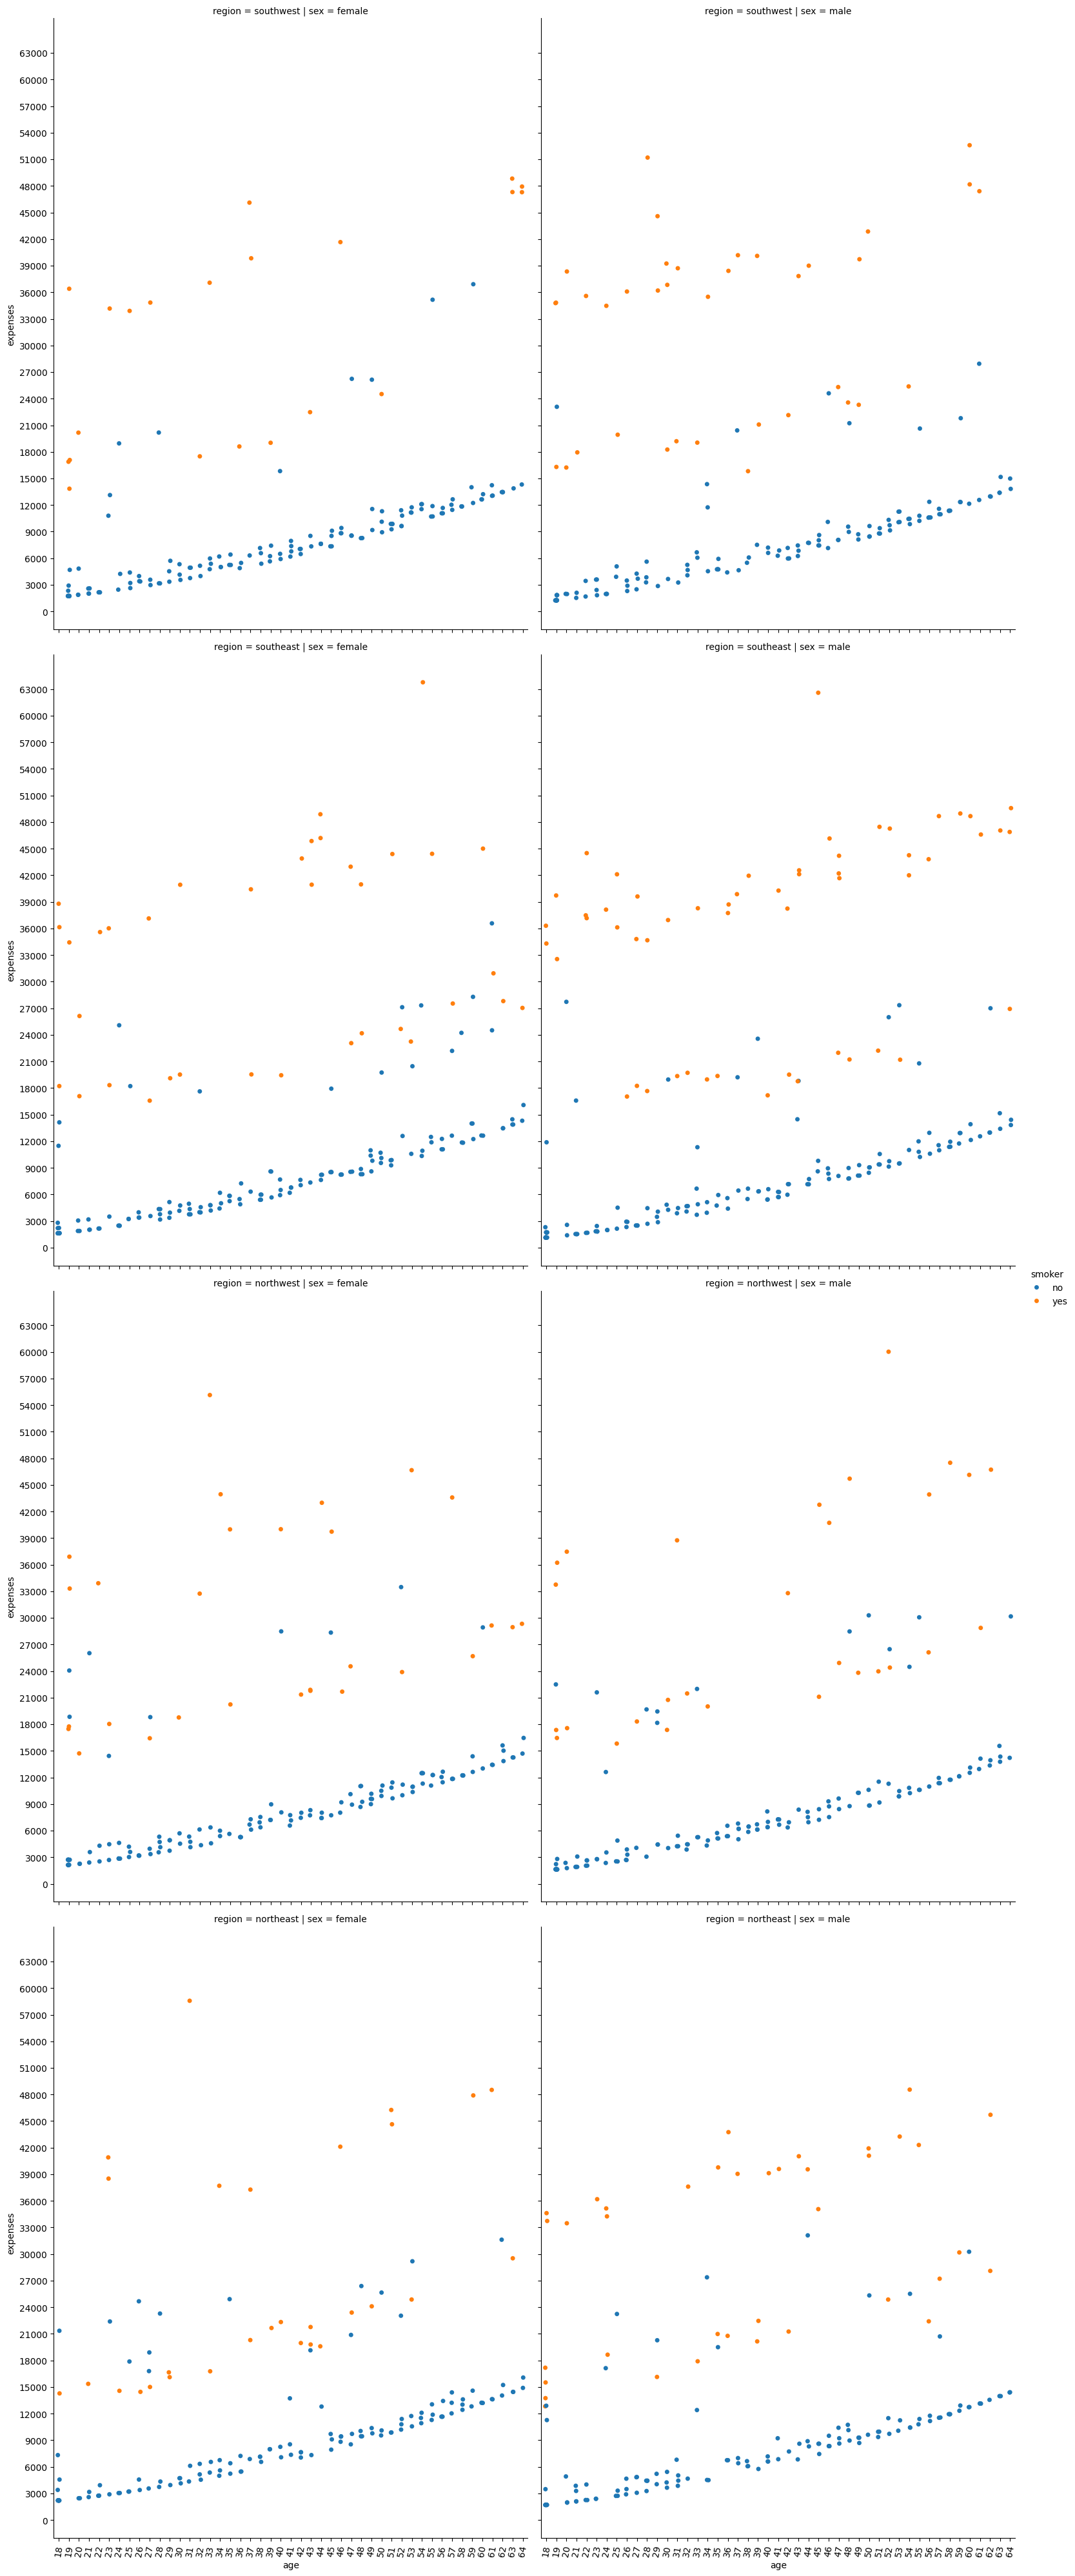

In [25]:
yticks = np.arange(0,64000,3000)
g = sns.catplot(data = df, 
                x = 'age', 
                y = 'expenses', 
                hue = 'smoker', 
                col = 'sex', 
                row = 'region', 
                estimator = 'median',
                height = 10, 
                aspect = 0.8,
                legend_out = True);

for ax in g.axes.flatten():
    ax.set_yticks(yticks)
    for label in ax.get_xticklabels():
        label.set_rotation(80)

## how number of children affects the expenses and also if the person is smoker

In [26]:
a3 = df[df['smoker']=='yes']

In [27]:
a3.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
11,62,female,26.3,0,yes,southeast,27808.73
14,27,male,42.1,0,yes,southeast,39611.76
19,30,male,35.3,0,yes,southwest,36837.47
23,34,female,31.9,1,yes,northeast,37701.88


In [28]:
# considering the mean of expenses for the group of age and children
a3_plot = a3.groupby(['age','children'])['expenses'].mean().reset_index()

In [29]:
a3_plot.head()

,age,children,expenses
0,18,0,27893.751250
1,18,1,17178.680000
2,18,2,23566.315000
3,18,3,18223.450000
4,19,0,27073.358125


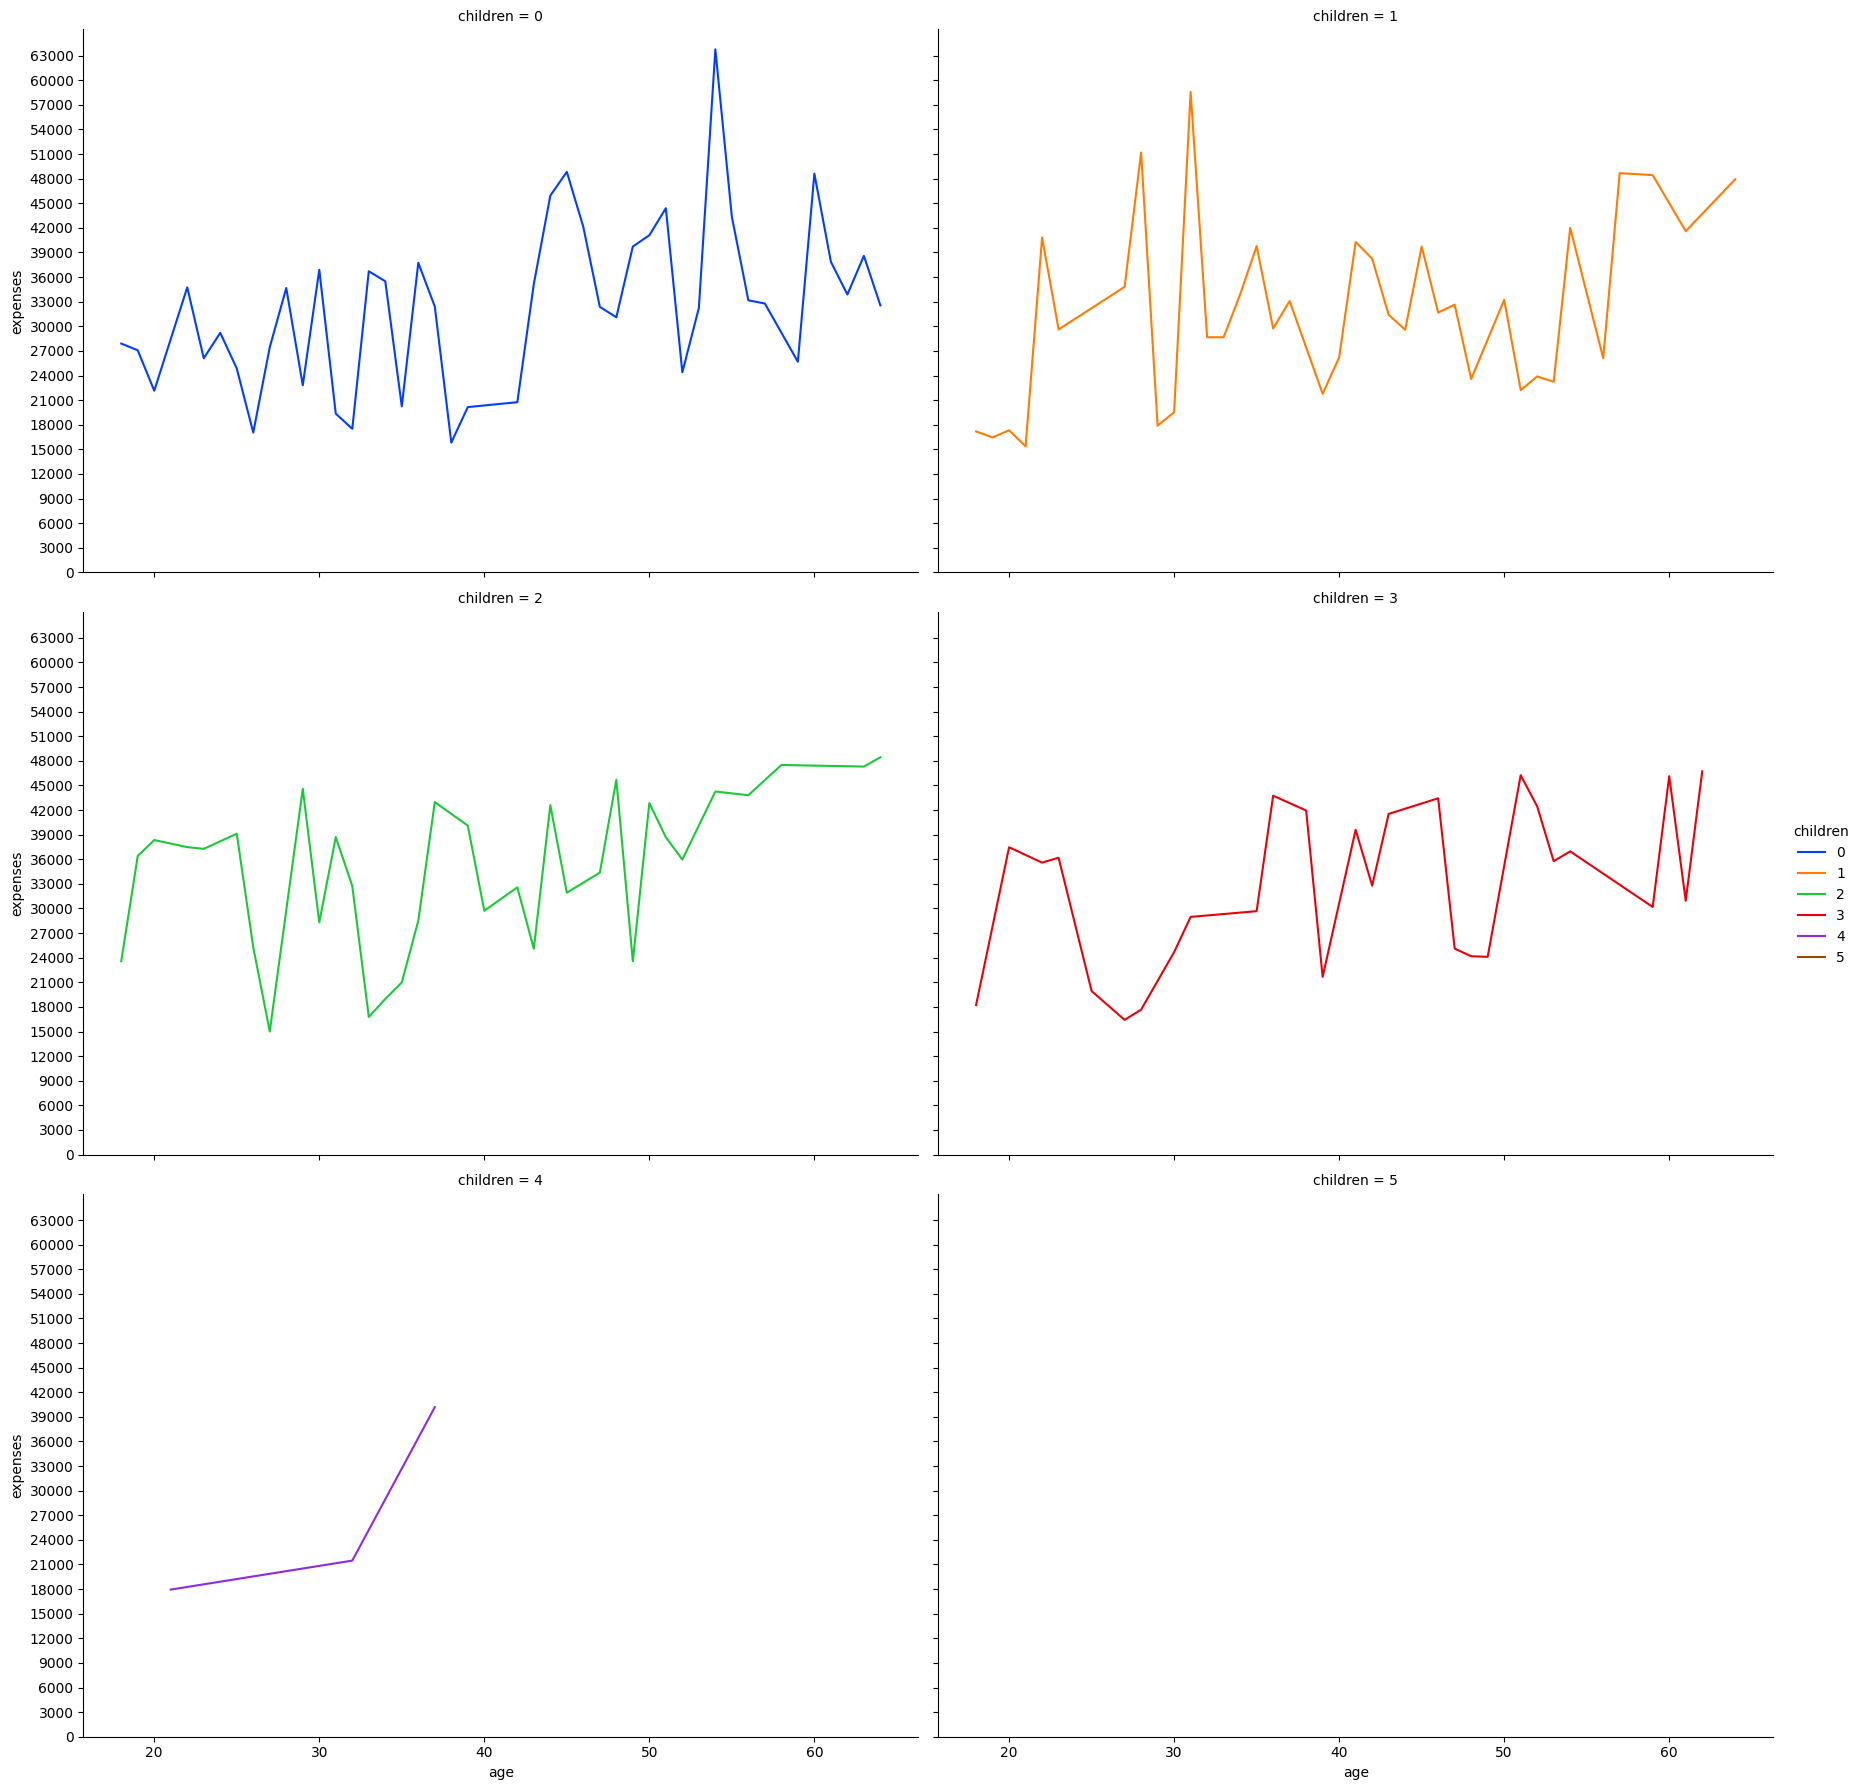

In [30]:
yticks = np.arange(0,64000,3000)

sns.relplot(data = a3_plot, 
            x = 'age', 
            y = 'expenses', 
            hue = 'children',
            col = 'children',
            col_wrap = 2,
            kind = 'line',
            height = 6,
            aspect = 1.5, 
            palette = 'bright')

plt.yticks(yticks);

# Premium Expenses as per the region

In [31]:
# considering the mean of expenses for the group of age and region
a5 = df.groupby(['region','age'])['expenses'].mean().reset_index()

In [32]:
a5.head()

,region,age,expenses
0,northeast,18,7558.733125
1,northeast,20,7876.546667
2,northeast,21,4637.122857
3,northeast,22,2952.242857
4,northeast,23,20813.061429


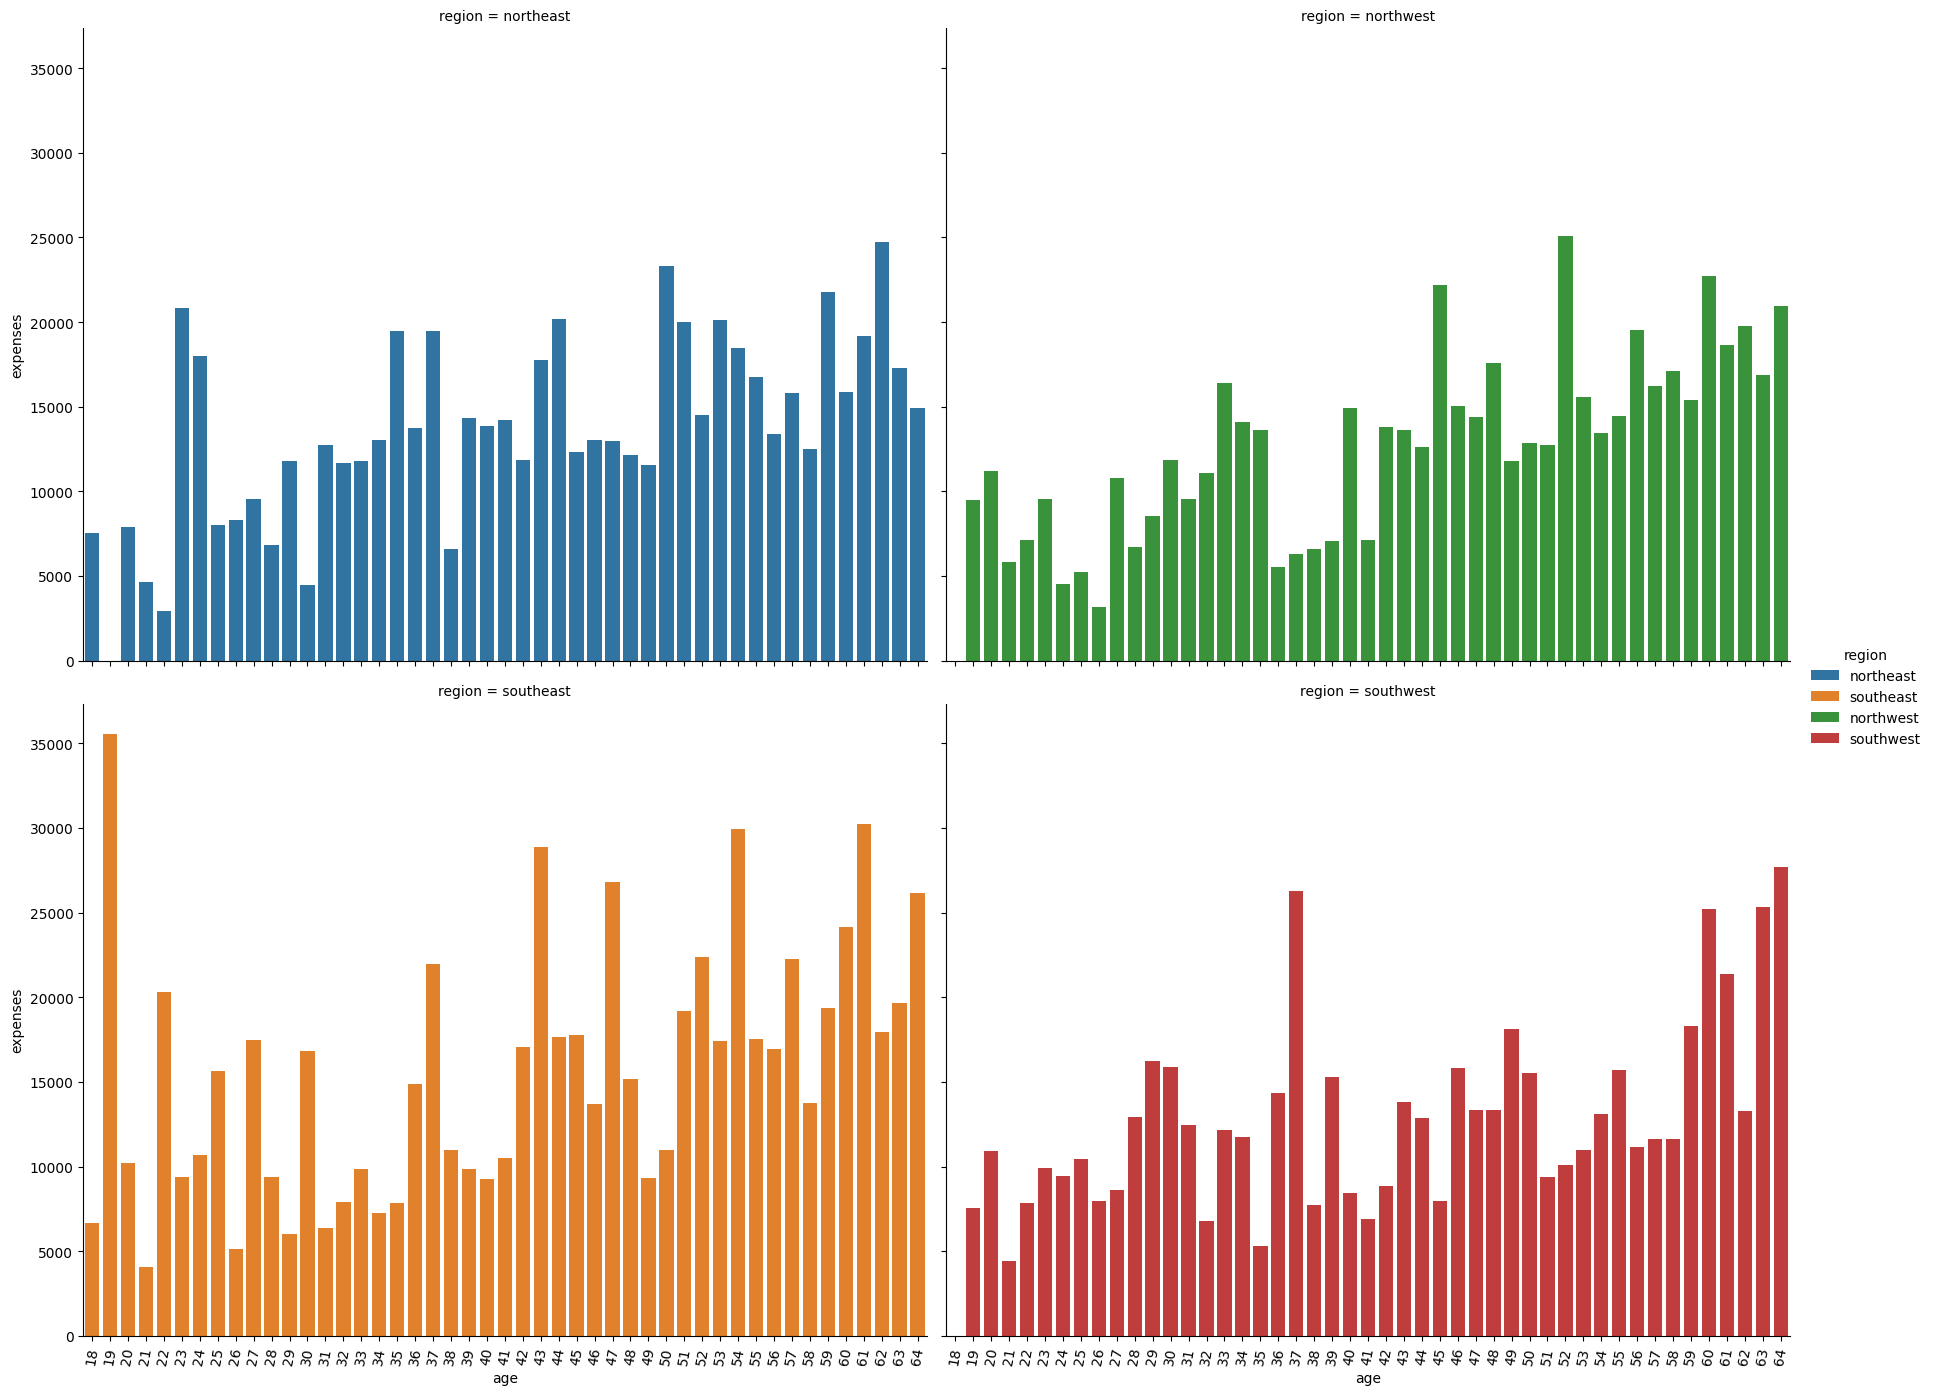

In [33]:
g = sns.catplot(data = a5, 
                x = 'age', 
                y = 'expenses', 
                hue = 'region', 
                col = 'region',
                col_wrap = 2,
                kind = 'bar',
                height = 7,
                aspect = 1.3)
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(80)

In [34]:
df.groupby(['smoker','region'])['expenses'].mean().sort_values(ascending = False)

smoker  region   
yes     southeast    34844.997253
        southwest    32269.064138
        northwest    30192.002759
        northeast    29673.536269
no      northeast     9165.531946
        northwest     8556.463558
        southeast     8032.216300
        southwest     8019.285019
Name: expenses, dtype: float64

In [35]:
df.groupby(['smoker','region'])['expenses'].median().sort_values(ascending = False)

smoker  region   
yes     southeast    37484.450
        southwest    35165.255
        northeast    28101.330
        northwest    27488.995
no      northeast     8342.910
        southwest     7348.140
        northwest     7256.720
        southeast     6652.530
Name: expenses, dtype: float64

# To check how BMI is affecting the expenses

In [36]:
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


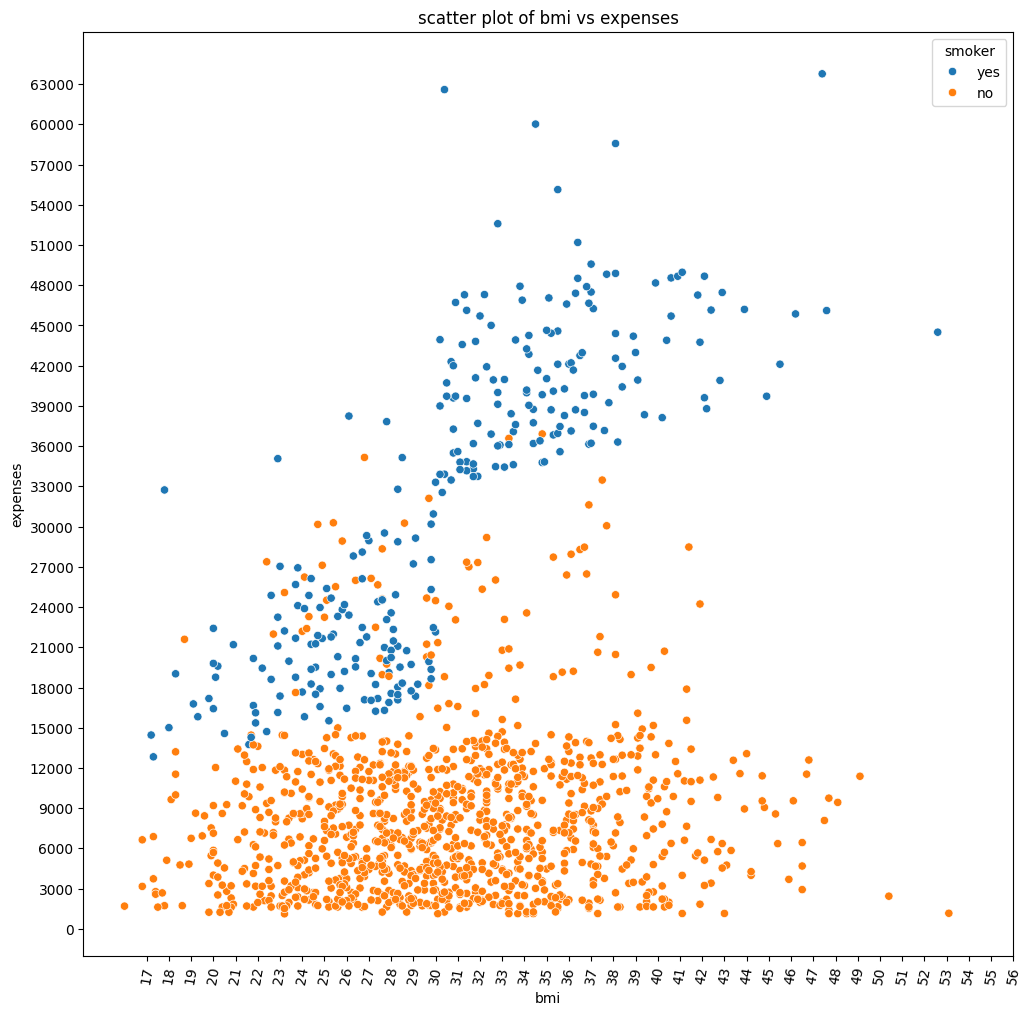

In [37]:
plt.figure(figsize = (12,12))
plt.title('scatter plot of bmi vs expenses')
sns.scatterplot(data = df, 
                x = 'bmi', 
                y = 'expenses',
                hue = 'smoker')
plt.xticks(np.arange(17,57,1),rotation = 80);
plt.yticks(np.arange(0,64000,3000));

# CONCLUSIONS

### from this EDA we can conclude that, The person who is a smoker is paying high premium

# MODEL TRAINING

In [38]:
df

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95


In [39]:
# applying square root transformation to remove the outliers
df['bmi'] = np.sqrt(df['bmi'])

In [40]:
# label encoding categorical columns(sex,smoker, region)
df['sex'] = df['sex'].map({'female':0, 'male':1})
df['smoker'] = df['smoker'].map({'no':0, 'yes':1})
df['region'] = df['region'].map({'southwest':0,
                                 'southeast':1,
                                 'northwest':2,
                                 'northeast':3 })

In [41]:
# seperating dependent and independent variables
x = df.drop(['expenses'], axis = 1)
y = df[['expenses']]

In [42]:
# splitting the dependent and independent variables to train set and test set
x_train,x_test,y_train,y_test = train_test_split(x, y,
                                                 test_size = 0.25, random_state = 0)

In [43]:
# applying standard scaler in a pipeline to scale the values 
pipeline = Pipeline(
    steps = [
        ('standard_scaler',StandardScaler())
    ]
)

In [44]:
# transforming train and test data
x_train_new = pd.DataFrame(pipeline.fit_transform(x_train),
                           columns = x.columns)
x_test_new = pd.DataFrame(pipeline.transform(x_test),
                          columns = x.columns)

In [45]:
x_train_new 

,age,sex,bmi,children,smoker,region
0,-0.514853,-0.985155,-0.130877,-0.063607,-0.503736,-0.390781
1,1.548746,-0.985155,-1.465482,-0.892144,-0.503736,1.419629
2,-1.439915,1.015069,-0.986161,-0.063607,-0.503736,-1.295987
3,-1.368757,-0.985155,-1.022104,-0.892144,1.985167,-0.390781
4,-0.941805,-0.985155,-1.427638,-0.892144,-0.503736,0.514424
...,...,...,...,...,...,...
998,-0.870646,1.015069,-0.738550,-0.892144,-0.503736,1.419629
999,0.196733,1.015069,0.864353,0.764931,-0.503736,-0.390781
1000,0.054415,1.015069,-0.896939,-0.892144,-0.503736,-0.390781
1001,-1.439915,1.015069,0.789966,-0.892144,-0.503736,0.514424


In [46]:
# dictionary of models which we use for training
models = {
    'linear':LinearRegression(),
    'Lasso':Lasso(),
    'ridge':Ridge(),
    'random':RandomForestRegressor(random_state = 13),
    'xg':XGBRegressor(random_state = 42),
    'Gradient':GradientBoostingRegressor(random_state = 42),
    'knn': KNeighborsRegressor()
}

In [47]:
# function to get the evaluation metrics
def evaluation(x_train, x_test, y_train, y_test, models):
    for key,value in models.items():
        model = value.fit(x_train,y_train)
        y_predict_test = model.predict(x_test)
        y_pred_train = model.predict(x_train)
        
        r2_train = r2_score(y_true = y_train,
                            y_pred = y_pred_train)
        
        r2 = r2_score(y_true = y_test,
                      y_pred = y_predict_test)
        
        rmse = root_mean_squared_error(y_true = y_test,
                                       y_pred = y_predict_test)
        mae = mean_absolute_error(y_true = y_test,
                                  y_pred = y_predict_test)
        print(key)
        print(f'r2_score_train : {r2_train}')
        print(f'r2_score : {r2}')
        print(f'RMSE : {rmse}')
        print(f'MAE : {mae}')
        print("%%%%%%%%%%%")

In [48]:
evaluation(x_train_new, x_test_new, y_train, y_test, models)

linear
r2_score_train : 0.7344316711617922
r2_score : 0.796059482932696
RMSE : 5666.328268922168
MAE : 4044.0755060369565
%%%%%%%%%%%
Lasso
r2_score_train : 0.7344316307227268
r2_score : 0.7960494786400388
RMSE : 5666.467247953712
MAE : 4043.9505491623663
%%%%%%%%%%%
ridge
r2_score_train : 0.7344309094308847
r2_score : 0.7959920404104912
RMSE : 5667.265110425578
MAE : 4046.2146461485413
%%%%%%%%%%%
random
r2_score_train : 0.9751029122307874
r2_score : 0.871013014179342
RMSE : 4506.329253126539
MAE : 2759.6212876019904
%%%%%%%%%%%
xg
r2_score_train : 0.9952712059020996
r2_score : 0.8287116289138794
RMSE : 5192.947117225039
MAE : 3222.233676382492
%%%%%%%%%%%
Gradient
r2_score_train : 0.8951649096532505
r2_score : 0.8972431932703069
RMSE : 4022.1223076929796
MAE : 2431.7848680859843
%%%%%%%%%%%
knn
r2_score_train : 0.861926199087774
r2_score : 0.8495439365060587
RMSE : 4866.926867393397
MAE : 3194.583880597015
%%%%%%%%%%%


In [49]:
# parameters of gradient boosting which is used for hyper-parameter tuning
gr_params = {
    'learning_rate':[0.05,0.1],
    'n_estimators': list(np.arange(100,401,50)),
    'max_depth': list(np.arange(1,8,2)),
    'criterion': ['squared_error', 'friedman_mse']
}

# parameters of random forest which is used for hyper-parameter tuning
rf_params = {
    'n_estimators' : list(np.arange(100,401,50)),
    'criterion' : ['squared_error', 'friedman_mse', 'poisson'],
    'max_depth' : list(np.arange(1,8,2))


}

In [50]:
# using gridsearch hyperparameter tuning for gradient boost and random forest
gr_boost = GridSearchCV(estimator = models['Gradient'],
                        param_grid = gr_params, 
                        cv = 10,
                        scoring = 'r2',
                        verbose = 3)

rf_grid = GridSearchCV(estimator = models['random'],
                        param_grid = rf_params, 
                        cv = 10,
                        scoring = 'r2',
                        verbose = 3)

In [51]:
gr_boost.fit(x_train_new,y_train)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits
[CV 1/10] END criterion=squared_error, learning_rate=0.05, max_depth=1, n_estimators=100;, score=0.764 total time=   0.0s
[CV 2/10] END criterion=squared_error, learning_rate=0.05, max_depth=1, n_estimators=100;, score=0.758 total time=   0.0s
[CV 3/10] END criterion=squared_error, learning_rate=0.05, max_depth=1, n_estimators=100;, score=0.644 total time=   0.0s
[CV 4/10] END criterion=squared_error, learning_rate=0.05, max_depth=1, n_estimators=100;, score=0.692 total time=   0.0s
[CV 5/10] END criterion=squared_error, learning_rate=0.05, max_depth=1, n_estimators=100;, score=0.615 total time=   0.0s
[CV 6/10] END criterion=squared_error, learning_rate=0.05, max_depth=1, n_estimators=100;, score=0.761 total time=   0.0s
[CV 7/10] END criterion=squared_error, learning_rate=0.05, max_depth=1, n_estimators=100;, score=0.684 total time=   0.0s
[CV 8/10] END criterion=squared_error, learning_rate=0.05, max_depth=1, n_estimat

GridSearchCV(cv=10, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'criterion': ['squared_error', 'friedman_mse'],
                         'learning_rate': [0.05, 0.1],
                         'max_depth': [1, 3, 5, 7],
                         'n_estimators': [100, 150, 200, 250, 300, 350, 400]},
             scoring='r2', verbose=3)

In [52]:
rf_grid.fit(x_train_new,y_train)

Fitting 10 folds for each of 84 candidates, totalling 840 fits
[CV 1/10] END criterion=squared_error, max_depth=1, n_estimators=100;, score=0.716 total time=   0.0s
[CV 2/10] END criterion=squared_error, max_depth=1, n_estimators=100;, score=0.671 total time=   0.0s
[CV 3/10] END criterion=squared_error, max_depth=1, n_estimators=100;, score=0.494 total time=   0.0s
[CV 4/10] END criterion=squared_error, max_depth=1, n_estimators=100;, score=0.486 total time=   0.0s
[CV 5/10] END criterion=squared_error, max_depth=1, n_estimators=100;, score=0.411 total time=   0.0s
[CV 6/10] END criterion=squared_error, max_depth=1, n_estimators=100;, score=0.676 total time=   0.0s
[CV 7/10] END criterion=squared_error, max_depth=1, n_estimators=100;, score=0.615 total time=   0.0s
[CV 8/10] END criterion=squared_error, max_depth=1, n_estimators=100;, score=0.590 total time=   0.0s
[CV 9/10] END criterion=squared_error, max_depth=1, n_estimators=100;, score=0.593 total time=   0.0s
[CV 10/10] END crit

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=13),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'poisson'],
                         'max_depth': [1, 3, 5, 7],
                         'n_estimators': [100, 150, 200, 250, 300, 350, 400]},
             scoring='r2', verbose=3)

In [53]:
# best parameters of gradient boost from hyperparameter tuning
best_gr = gr_boost.best_params_

# best parameters of random forest from hyperparameter tuning
best_rf = rf_grid.best_params_

In [54]:
best_gr

{'criterion': 'squared_error',
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 100}

In [55]:
best_rf

{'criterion': 'poisson', 'max_depth': 3, 'n_estimators': 150}

In [56]:
# best score of gradient boost from hyperparameter tuning
gr_boost.best_score_

0.8389496921622286

In [57]:
# best score of random forest from hyperparameter tuning
rf_grid.best_score_

0.8335609931727468

In [58]:
# models for training which are used with best parameters
new_models = {
    'best_gradient' : GradientBoostingRegressor(**best_gr),
    'best_random_forest' : RandomForestRegressor(**best_rf)
}


In [59]:
# evaluating the models with best parameters
evaluation(x_train_new, x_test_new, y_train, y_test, new_models)

best_gradient
r2_score_train : 0.8763964843069415
r2_score : 0.9011148640684231
RMSE : 3945.6220359020663
MAE : 2469.3051377322454
%%%%%%%%%%%
best_random forest
r2_score_train : 0.8490927418047396
r2_score : 0.8941255058458385
RMSE : 4082.682875316634
MAE : 2562.496421815304
%%%%%%%%%%%
